In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
from sklearn.cluster import Birch
import skfuzzy as fuzz
from tqdm import tqdm
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse
import mplcursors
import plotly.express as px
import plotly.graph_objects as go
from sklearn.covariance import empirical_covariance
from sklearn.preprocessing import StandardScaler

In [ ]:
from importlib.machinery import SourceFileLoader
foo = SourceFileLoader("gfg", '/home/arneyh/scotforgeproject1/mod/dataset.py').load_module()
#from mod.dataset import DataSet

In [ ]:
final_df = foo.DataSet()

In [ ]:
final_df = final_df.final_customer_df
final_df.tail(3)

In [ ]:
# pip install scikit-learn-extra
# Uncomment if first cell fails

In [ ]:
pd.set_option('display.max_columns', None)
file_path = '~/scotforgeproject1/csv_datasets/'
df = pd.read_csv(file_path + "Customer_Location.csv")

# Only keeping the 2.5k Customers in all
df = df[df['Customer ID'].isin(final_df['Customer ID'])]
df.reset_index(drop=True, inplace=True)

df = pd.merge(df, final_df[['Customer ID', 'Subsegment Code']], on='Customer ID', how='left')

# Making an extra Coordinate column that combines longitude and latitude to easier compare with other features
df['Coordinate'] = df.apply(lambda row: (row['Longitude'], row['Latitude']), axis=1)

region_encoded_df = pd.get_dummies(df['Region'], prefix='Region')
df = pd.concat([df, region_encoded_df], axis=1)
df.drop(columns=['Region'], inplace=True)

df.tail(3)

In [ ]:
us_df = df[df['Country'] == 'US']
non_us_df = df[df['Country'] != 'US']

us_df.reset_index(drop=True, inplace=True)
non_us_df.reset_index(drop=True, inplace=True)

In [ ]:
us_df.tail(1)

In [ ]:
non_us_df.tail(1)

In [ ]:
df.describe()

In [ ]:
df.shape

In [ ]:
df.columns

#### Number of values

In [ ]:
for column in df.columns:
    print(f'{column}: {df[column].count()}')

#### Unique Values

In [ ]:
for column in df.columns:
    print(f'{column}: {df[column].nunique()}')

#### Type of Data

In [ ]:
for column in df.columns:
    print(f'{column}: {df[column].dtype}')

In [ ]:
for column in df.columns:
    print(f'{column}: {pd.api.types.is_numeric_dtype(df[column])}')

#### Checking for null values

In [ ]:
for column in df.columns:
    print(f'{column}: {df[column].isnull().sum()}')

## Fuzzy Clustering

In [ ]:
def fuzzy_clustering(dataset, num_clusters, fuzziness=2, max_iterations=100, tolerance=1e-5):
    """
    Apply fuzzy clustering to a dataset.

    Parameters:
        dataset (numpy.ndarray): The dataset to cluster.
        num_clusters (int): The number of clusters to create.
        fuzziness (float): The fuzziness parameter (default=2).
        max_iterations (int): The maximum number of iterations for the clustering algorithm (default=100).
        tolerance (float): The convergence criterion (default=1e-5).

    Returns:
        centroids (numpy.ndarray): The centroids of the clusters.
        membership (numpy.ndarray): The membership values for each data point.
    """

    # Transpose the dataset so that each row represents a data point
    dataset = dataset.T

    # Initialize the centroids randomly
    centroids = np.random.rand(num_clusters, dataset.shape[1])

    # Apply fuzzy c-means clustering
    centroids, membership, _, _, _, _, _ = fuzz.cluster.cmeans(
        dataset, num_clusters, fuzziness, error=tolerance, maxiter=max_iterations)

    return centroids, membership

In [ ]:
def calculate_silhouette_score(data, num_clusters):
    """
    Calculate the silhouette score for a given number of clusters using fuzzy clustering.

    Parameters:
        data (numpy.ndarray): The data to cluster.
        num_clusters (int): The number of clusters.

    Returns:
        silhouette_score (float): The silhouette score.
    """
    centroids, membership = fuzzy_clustering(data, num_clusters)  # Perform fuzzy clustering
    labels = np.argmax(membership, axis=0)  # Convert membership matrix to cluster labels
    if len(np.unique(labels)) < 2:
        return -1  # Return a negative value to indicate empty clusters
    score = silhouette_score(data, labels)
    return score

In [ ]:
def compute_covariance(selected_data, membership, centroids, cluster_index):
    cluster_points = selected_data[membership.argmax(axis=0) == cluster_index]
    covariance_matrix = np.cov(cluster_points.T)
    return covariance_matrix

### Testing to see the right number of Clusters is most optimal

In [ ]:
feature_combinations = [['Longitude', 'Latitude']]

num_clusters_range = range(2, 16)  # Test 2 to 15 clusters
best_num_clusters = None
best_score = -1
silhouette_scores_list = []  

for num_clusters in tqdm(num_clusters_range):
    silhouette_scores = []
    for features in feature_combinations:
        selected_data = us_df[features].values
        score = calculate_silhouette_score(selected_data, num_clusters)
        silhouette_scores.append(score)
    avg_score = np.mean(silhouette_scores)
    silhouette_scores_list.append(avg_score)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(num_clusters_range, silhouette_scores_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs Number of Clusters')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

In [ ]:
north_america_bounds = {
    "min_longitude": -125.0,
    "max_longitude": -67.0,
    "min_latitude": 24.0,
    "max_latitude": 49.0
}

num_clusters = 2
for features in feature_combinations:
    selected_data = us_df[features].values
    
    # Filter data points within North America
    is_in_north_america = np.logical_and.reduce([
        selected_data[:, 0] >= north_america_bounds["min_longitude"],
        selected_data[:, 0] <= north_america_bounds["max_longitude"],
        selected_data[:, 1] >= north_america_bounds["min_latitude"],
        selected_data[:, 1] <= north_america_bounds["max_latitude"]
    ])
    selected_data = selected_data[is_in_north_america]
    centroids, membership = fuzzy_clustering(selected_data, num_clusters)
    
    fig, ax = plt.subplots(figsize=(20, 10))

    # Clusters
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(selected_data[membership.argmax(axis=0) == i, 0], selected_data[membership.argmax(axis=0) == i, 1], label=f'Cluster {i+1}', alpha=0.5, color=cluster_color)

    # Centroids
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(centroids[i, 0], centroids[i, 1], marker='X', color=cluster_color, edgecolors='black', linewidth=1, s=100)

        covariance_matrix = compute_covariance(selected_data, membership, centroids, i)

        # Plot ellipse around centroids
        ellipse = Ellipse((centroids[i, 0], centroids[i, 1]), 2*np.sqrt(5.991*covariance_matrix[0, 0]), 2*np.sqrt(5.991*covariance_matrix[1, 1]), np.degrees(np.arccos(covariance_matrix[0, 1]/np.sqrt(covariance_matrix[0, 0]*covariance_matrix[1, 1]))), edgecolor=cluster_color, linestyle='--', fill=True, alpha=0.1, lw=2, facecolor=cluster_color)
        ax.add_patch(ellipse)

    ax.set_title(f'Fuzzy Clustering Results (US Only): {features[0]} vs {features[1]}')
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.legend()
    
    plt.grid(True)
    plt.show()

______________________________________________________________________________

In [ ]:
feature_combinations = [['Longitude', 'Latitude', 'Subsegment Code']]

# Test 2 to 15 clusters
num_clusters_range = range(2, 16)
best_num_clusters = None
best_score = -1
silhouette_scores_list = []

for num_clusters in tqdm(num_clusters_range):
    silhouette_scores = []
    for features in feature_combinations:
        # Extracting selected features
        selected_data = us_df[features].values
        
        # Standardize the data (optional but recommended for clustering)
        scaler = StandardScaler()
        selected_data_scaled = scaler.fit_transform(selected_data)
        
        # Calculate silhouette score
        score = calculate_silhouette_score(selected_data_scaled, num_clusters)
        silhouette_scores.append(score)
    avg_score = np.mean(silhouette_scores)
    silhouette_scores_list.append(avg_score)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(num_clusters_range, silhouette_scores_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs Number of Clusters')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

In [ ]:
subsegment_counts = us_df['Subsegment Code'].value_counts()
print("Subsegment Code Counts:")
for code, count in subsegment_counts.items():
    print(f"Subsegment Code {code}: {count}")


In [ ]:
subsegment_counts = non_us_df['Subsegment Code'].value_counts()
print("Subsegment Code Counts:")
for code, count in subsegment_counts.items():
    print(f"Subsegment Code {code}: {count}")


In [ ]:
subsegment_counts = df['Subsegment Code'].value_counts()
print("Subsegment Code Counts:")
for code, count in subsegment_counts.items():
    print(f"Subsegment Code {code}: {count}")


In [ ]:
from imblearn.over_sampling import RandomOverSampler

subsegment_counts = us_df['Subsegment Code'].value_counts()

# Print the counts for each subsegment code
print("Subsegment Code Counts:")
for code, count in subsegment_counts.items():
    print(f"Subsegment Code {code}: {count}")

# Apply Random Oversampling to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(us_df.drop('Subsegment Code', axis=1), us_df['Subsegment Code'])

# Create a DataFrame from the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=us_df.drop('Subsegment Code', axis=1).columns)
resampled_df['Subsegment Code'] = y_resampled

# Count the occurrences of each unique subsegment code in the resampled DataFrame
resampled_subsegment_counts = resampled_df['Subsegment Code'].value_counts()

# Print the counts for each subsegment code in the resampled DataFrame
print("\nSubsegment Code Counts (After Resampling):")
for code, count in resampled_subsegment_counts.items():
    print(f"Subsegment Code {code}: {count}")

In [ ]:
for features in feature_combinations:
    selected_data = us_df[features].values
    
    # Filter data points within North America
    is_in_north_america = np.logical_and.reduce([
        selected_data[:, 0] >= north_america_bounds["min_longitude"],
        selected_data[:, 0] <= north_america_bounds["max_longitude"],
        selected_data[:, 1] >= north_america_bounds["min_latitude"],
        selected_data[:, 1] <= north_america_bounds["max_latitude"]
    ])
    selected_data = selected_data[is_in_north_america]
    subsegment_codes = us_df.loc[is_in_north_america, 'Subsegment Code'].values
    
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot points with unique colors for each subsegment code
    unique_subsegment_codes = np.unique(subsegment_codes)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_subsegment_codes)))
    for code, color in zip(unique_subsegment_codes, colors):
        ax.scatter(selected_data[subsegment_codes == code, 0], selected_data[subsegment_codes == code, 1], label=f'Subsegment {code}', alpha=0.5, color=color)

    ax.set_title(f'Fuzzy Clustering Results (US Only): {features[0]} vs {features[1]}')
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.legend(title='Subsegment Code', loc='upper right')
    
    plt.grid(True)
    plt.show()

In [ ]:
north_america_bounds = {
    "min_longitude": -125.0,
    "max_longitude": -67.0,
    "min_latitude": 24.0,
    "max_latitude": 49.0
}

num_clusters = 2
for features in feature_combinations:
    selected_data = us_df[features].values
    
    # Filter data points within North America
    is_in_north_america = np.logical_and.reduce([
        selected_data[:, 0] >= north_america_bounds["min_longitude"],
        selected_data[:, 0] <= north_america_bounds["max_longitude"],
        selected_data[:, 1] >= north_america_bounds["min_latitude"],
        selected_data[:, 1] <= north_america_bounds["max_latitude"]
    ])
    selected_data = selected_data[is_in_north_america]
    centroids, membership = fuzzy_clustering(selected_data, num_clusters)
    
    fig, ax = plt.subplots(figsize=(20, 10))

    # Clusters
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(selected_data[membership.argmax(axis=0) == i, 0], selected_data[membership.argmax(axis=0) == i, 1], label=f'Cluster {i+1}', alpha=0.5, color=cluster_color)

    # Centroids
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(centroids[i, 0], centroids[i, 1], marker='X', color=cluster_color, edgecolors='black', linewidth=1, s=100)

        covariance_matrix = compute_covariance(selected_data, membership, centroids, i)

        # Plot ellipse around centroids
        ellipse = Ellipse((centroids[i, 0], centroids[i, 1]), 2*np.sqrt(5.991*covariance_matrix[0, 0]), 2*np.sqrt(5.991*covariance_matrix[1, 1]), np.degrees(np.arccos(covariance_matrix[0, 1]/np.sqrt(covariance_matrix[0, 0]*covariance_matrix[1, 1]))), edgecolor=cluster_color, linestyle='--', fill=True, alpha=0.1, lw=2, facecolor=cluster_color)
        ax.add_patch(ellipse)

    ax.set_title(f'Fuzzy Clustering Results (US Only): {features[0]} vs {features[1]} vs {features[2]}')
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.legend()
    
    plt.grid(True)
    plt.show()

______________________________________________________________________________________________________________________________

In [ ]:
feature_combinations = [['Longitude', 'Latitude']]

num_clusters_range = range(2, 16)  # Test 2 to 15 clusters
best_num_clusters = None
best_score = -1
silhouette_scores_list = []  

for num_clusters in tqdm(num_clusters_range):
    silhouette_scores = []
    for features in feature_combinations:
        selected_data = non_us_df[features].values
        score = calculate_silhouette_score(selected_data, num_clusters)
        silhouette_scores.append(score)
    avg_score = np.mean(silhouette_scores)
    silhouette_scores_list.append(avg_score)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(num_clusters_range, silhouette_scores_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs Number of Clusters')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

In [ ]:
feature_combinations = [['Longitude', 'Latitude']]

# Apply fuzzy clustering and visualize clusters for each feature combination
num_clusters = 3
for features in feature_combinations:
    selected_data = non_us_df[features].values
    centroids, membership = fuzzy_clustering(selected_data, num_clusters)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Clusters
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(selected_data[membership.argmax(axis=0) == i, 0], selected_data[membership.argmax(axis=0) == i, 1], label=f'Cluster {i+1}', alpha=0.5, color=cluster_color)
    
    # Centroids
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(centroids[i, 0], centroids[i, 1], marker='X', color=cluster_color, edgecolors='black', linewidth=1, s=100)
        covariance_matrix = compute_covariance(selected_data, membership, centroids, i)

        # Plot ellipse around centroids
        ellipse = Ellipse((centroids[i, 0], centroids[i, 1]), 2*np.sqrt(5.991*covariance_matrix[0, 0]), 2*np.sqrt(5.991*covariance_matrix[1, 1]), np.degrees(np.arccos(covariance_matrix[0, 1]/np.sqrt(covariance_matrix[0, 0]*covariance_matrix[1, 1]))), edgecolor=cluster_color, linestyle='--', fill=True, alpha=0.1, lw=2, facecolor=cluster_color)
        ax.add_patch(ellipse)

    ax.set_title(f'Fuzzy Clustering Results Non-US: {features[0]} vs {features[1]}')
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.legend()
    
    #mplcursors.cursor(scatter_plots, hover=True).connect("add", lambda sel: sel.annotation.set_text(df.iloc[sel.target.index]["Country"]))

    
    plt.grid(True)
    plt.show()

In [ ]:
feature_combinations = [
    ['Longitude', 'Region_Asia'], 
    ['Longitude', 'Region_Australia'], 
    #['Longitude', 'Region_Canada'], 
    #['Longitude', 'Region_Central America'], 
    ['Longitude', 'Region_Europe'], 
    ['Longitude', 'Region_Great Lakes'], 
    ['Longitude', 'Region_Mid East'], 
    ['Longitude', 'Region_New England'], 
    ['Longitude', 'Region_North America'], 
    ['Longitude', 'Region_Plains'], 
    ['Longitude', 'Region_Rocky Mountain'], 
    ['Longitude', 'Region_South America'], 
    ['Longitude', 'Region_Southeast'], 
    ['Longitude', 'Region_Southwest'], 
    ['Longitude', 'Region_West'], 
    ['Latitude', 'Region_Asia'], 
    ['Latitude', 'Region_Australia'], 
    #['Latitude', 'Region_Canada'], 
    #['Latitude', 'Region_Central America'], 
    ['Latitude', 'Region_Europe'], 
    ['Latitude', 'Region_Great Lakes'], 
    ['Latitude', 'Region_Mid East'], 
    ['Latitude', 'Region_New England'], 
    ['Latitude', 'Region_North America'], 
    ['Latitude', 'Region_Plains'], 
    ['Latitude', 'Region_Rocky Mountain'], 
    ['Latitude', 'Region_South America'], 
    ['Latitude', 'Region_Southeast'], 
    ['Latitude', 'Region_Southwest'], 
    ['Latitude', 'Region_West']
]


num_clusters_range = range(2, 16)  # Test 2 to 15 clusters
best_num_clusters = None
best_score = -1
silhouette_scores_list = []  

#for num_clusters in tqdm(num_clusters_range):
#    silhouette_scores = []
#    for features in feature_combinations:
#        selected_data = df[features].values
#        score = calculate_silhouette_score(selected_data, num_clusters)
#        silhouette_scores.append(score)
#    avg_score = np.mean(silhouette_scores)
#    silhouette_scores_list.append(avg_score)

In [ ]:
#plt.figure(figsize=(10, 6))
#plt.bar(num_clusters_range, silhouette_scores_list)
#plt.xlabel('Number of Clusters')
#plt.ylabel('Average Silhouette Score')
#plt.title('Average Silhouette Score vs Number of Clusters - Using Regions')
#plt.xticks(num_clusters_range)
#plt.grid(True)
#plt.show()

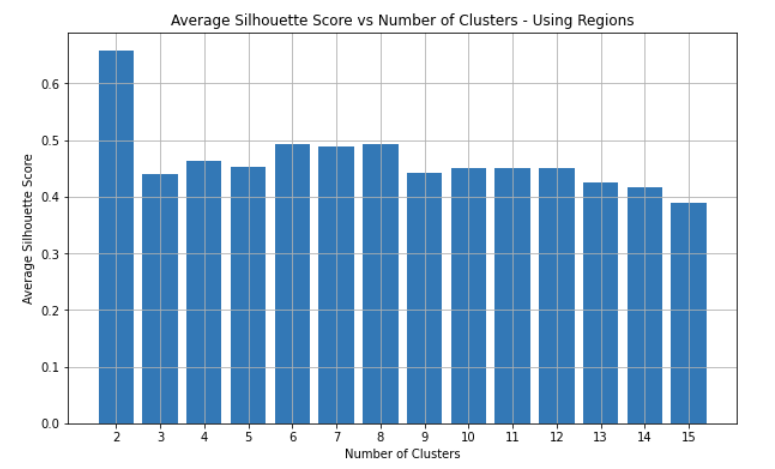

In [ ]:
num_clusters = 4
'''
for features in feature_combinations:
    selected_data = df[features].values
    centroids, membership = fuzzy_clustering(selected_data, num_clusters)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Clusters
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(selected_data[membership.argmax(axis=0) == i, 0], selected_data[membership.argmax(axis=0) == i, 1], label=f'Cluster {i+1}', alpha=0.5, color=cluster_color)
    
    # Centroids
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(centroids[i, 0], centroids[i, 1], marker='X', color=cluster_color, edgecolors='black', linewidth=1, s=100)
        covariance_matrix = compute_covariance(selected_data, membership, centroids, i)

        # Plot ellipse around centroids
        ellipse = Ellipse((centroids[i, 0], centroids[i, 1]), 2*np.sqrt(5.991*covariance_matrix[0, 0]), 2*np.sqrt(5.991*covariance_matrix[1, 1]), np.degrees(np.arccos(covariance_matrix[0, 1]/np.sqrt(covariance_matrix[0, 0]*covariance_matrix[1, 1]))), edgecolor=cluster_color, linestyle='--', fill=True, alpha=0.1, lw=2, facecolor=cluster_color)
        ax.add_patch(ellipse)

    ax.set_title(f'Fuzzy Clustering Results Non-US: {features[0]} vs {features[1]}')
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.legend()
    
    plt.grid(True)
    plt.show()'''

# Replace the dataset below with the desired dataset

## Here's how fuzzy clustering works:

1. Initialization: Fuzzy clustering starts with an initial guess of cluster centers (centroids) or membership values.

2. Membership Assignment: In each iteration, the algorithm calculates the degree of membership for each data point in each cluster. The membership values are typically between 0 and 1, and they indicate the probability or degree to which a data point belongs to a cluster.

3. Centroid Update: Once the membership values are calculated, the centroids of the clusters are updated based on these membership values. The centroids are recalculated as the weighted average of all data points, where the weights are given by the membership values.

4. Iteration: Steps 2 and 3 are repeated iteratively until either convergence is achieved (i.e., the centroids stabilize) or a predefined stopping criterion is met (such as maximum number of iterations).

5. Cluster Interpretation: After convergence, the algorithm provides not only the cluster assignments for each data point but also the degree to which each data point belongs to each cluster. This allows for a more nuanced interpretation of the clustering results, as data points can belong partially to multiple clusters.

### Removing some of the noisy data

In [ ]:
selected_features = ['Longitude', 'Latitude']

# Calculate z-scores for selected features
z_scores = np.abs((df[selected_features] - df[selected_features].mean()) / df[selected_features].std())

# Define a threshold for z-score
z_score_threshold = 3

# Find indices of rows where z-scores exceed the threshold for any selected feature
outlier_indices = z_scores[(z_scores > z_score_threshold).any(axis=1)].index

# Remove rows with noisy data
cleaned_df = df.drop(outlier_indices)

# Print the shape of the cleaned dataset to check the number of removed rows
print("Shape of original dataset:", df.shape)
print("Shape of cleaned dataset:", cleaned_df.shape)

In [ ]:
feature_combinations = [['Longitude', 'Latitude']]

num_clusters_range = range(2, 16)  # Test 2 to 15 clusters
best_num_clusters = None
best_score = -1
silhouette_scores_list = []  

for num_clusters in tqdm(num_clusters_range):
    silhouette_scores = []
    for features in feature_combinations:
        selected_data = cleaned_df[features].values
        score = calculate_silhouette_score(selected_data, num_clusters)
        silhouette_scores.append(score)
    avg_score = np.mean(silhouette_scores)
    silhouette_scores_list.append(avg_score)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(num_clusters_range, silhouette_scores_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs Number of Clusters')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

In [ ]:
selected_features = ['Longitude', 'Latitude']
cleaned_data = cleaned_df[selected_features].values

In [ ]:
# Apply fuzzy clustering to the cleaned dataset
num_clusters = 2
for features in feature_combinations:
    selected_data = cleaned_df[features].values
    centroids, membership = fuzzy_clustering(selected_data, num_clusters)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Clusters
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(selected_data[membership.argmax(axis=0) == i, 0], selected_data[membership.argmax(axis=0) == i, 1], label=f'Cluster {i+1}', alpha=0.5, color=cluster_color)
    
    # Centroids
    for i in range(num_clusters):
        cluster_color = plt.cm.tab10(i)
        ax.scatter(centroids[i, 0], centroids[i, 1], marker='X', color=cluster_color, edgecolors='black', linewidth=1, s=100)
        covariance_matrix = compute_covariance(selected_data, membership, centroids, i)

        # Plot ellipse around centroids
        ellipse = Ellipse((centroids[i, 0], centroids[i, 1]), 2*np.sqrt(5.991*covariance_matrix[0, 0]), 2*np.sqrt(5.991*covariance_matrix[1, 1]), np.degrees(np.arccos(covariance_matrix[0, 1]/np.sqrt(covariance_matrix[0, 0]*covariance_matrix[1, 1]))), edgecolor=cluster_color, linestyle='--', fill=True, alpha=0.1, lw=2, facecolor=cluster_color)
        ax.add_patch(ellipse)

    ax.set_title(f'Fuzzy Clustering Results Cleaned Data: {features[0]} vs {features[1]}')
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.legend()
    
    #mplcursors.cursor(scatter_plots, hover=True).connect("add", lambda sel: sel.annotation.set_text(df.iloc[sel.target.index]["Country"]))

    
    plt.grid(True)
    plt.show()


#### Latitude vs. Longitude Cleaned

In [ ]:
# Select the features for which you want to remove noisy data
selected_features = ['Latitude', 'Longitude']

# Calculate z-scores for selected features
z_scores = np.abs((df[selected_features] - df[selected_features].mean()) / df[selected_features].std())

# Define a threshold for z-score
z_score_threshold = 3

# Find indices of rows where z-scores exceed the threshold for any selected feature
outlier_indices = z_scores[(z_scores > z_score_threshold).any(axis=1)].index

# Remove rows with noisy data
cleaned_df = df.drop(outlier_indices)

# Print the shape of the cleaned dataset to check the number of removed rows
print("Shape of original dataset:", df.shape)
print("Shape of cleaned dataset:", cleaned_df.shape)


In [ ]:
cleaned_data = cleaned_df[selected_features].values

# Apply fuzzy clustering to the cleaned dataset
num_clusters = 2  # Define the number of clusters
centroids, membership = fuzzy_clustering(cleaned_data, num_clusters)

# Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data points with colors representing cluster membership
for i in range(num_clusters):
    cluster_color = plt.cm.tab10(i)  # Get a color from the tab10 colormap
    ax.scatter(cleaned_data[membership.argmax(axis=0) == i, 1], cleaned_data[membership.argmax(axis=0) == i, 0], label=f'Cluster {i+1}', alpha=0.5, color=cluster_color)

# Plot centroids with the same color as the clusters and black outline
for i in range(num_clusters):
    cluster_color = plt.cm.tab10(i) 
    ax.scatter(centroids[i, 1], centroids[i, 0], marker='X', color=cluster_color, edgecolors='black', linewidth=1, s=100)

ax.set_title('Fuzzy Clustering Results (Cleaned Data)')
ax.set_xlabel(selected_features[1])
ax.set_ylabel(selected_features[0])
ax.legend()
plt.grid(True)
plt.show()


## Subspace Clustering

In [ ]:
def subspace_clustering(dataset, num_clusters, feature_combinations):
    """
    Apply subspace clustering to a dataset using KMeans.

    Parameters:
        dataset (numpy.ndarray): The dataset to cluster.
        num_clusters (int): The number of clusters to create.
        feature_combinations (list of lists): The list of feature combinations to use for clustering.

    Returns:
        clusters (list of tuples): List of tuples containing centroids and labels for each feature combination.
    """
    clusters = []
    for features in feature_combinations:
        # Select only the features in the feature_combination
        selected_data = dataset[:, features]
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(selected_data)
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        
        clusters.append((centroids, labels))
    
    return clusters


### Cell is performing sub space clustering using KMeans. 
### Replace the dataset below with the desired dataset

In [ ]:
# List of feature combinations for subspace clustering
subspace_combinations = [
    ['Latitude', 'Longitude']  # Feature indices for first combination
    #[2, 3]  # Feature indices for second combination
    #[4, 5],  # Feature indices for third combination
    #[6, 7]   # Feature indices for fourth combination
]


# Applying subspace clustering
num_clusters = 3
clusters = subspace_clustering(df[subspace_combinations].values, num_clusters, subspace_combinations)

# Visualize the clusters for each feature combination
for i, (centroids, labels) in enumerate(clusters):
    features = subspace_combinations[i]
    print(features)
    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(num_clusters):
        cluster_color = plt.cm.tab10(j)  
        ax.scatter(df.iloc[:, features[0]][labels == j], 
                   df.iloc[:, features[1]][labels == j], 
                   label=f'Cluster {j+1}', alpha=0.5, color=cluster_color)
    for j in range(num_clusters):
        cluster_color = plt.cm.tab10(j) 
        ax.scatter(centroids[j, 0], centroids[j, 1], marker='X', color=cluster_color, 
                   edgecolors='black', linewidth=1, s=100, label=f'Centroid {j+1}')
    ax.set_title(f'Subspace Clustering Results: {data.feature_names[features[0]]} vs {data.feature_names[features[1]]}')
    ax.set_xlabel(data.feature_names[features[0]])
    ax.set_ylabel(data.feature_names[features[1]])
    ax.legend()
    plt.grid(True)
    plt.show()


## BIRCH Algorithm

#### LINK: https://www.sciencedirect.com/science/article/pii/S2214579617300151

In [ ]:
def apply_birch(dataset, threshold, branching_factor):
    """
    Apply BIRCH clustering to a dataset.

    Parameters:
        dataset (numpy.ndarray): The dataset to cluster.
        threshold (float): The branching factor threshold.
        branching_factor (int): The maximum number of subclusters in each leaf node.

    Returns:
        labels (numpy.ndarray): Array containing the cluster labels for each data point.
    """
    birch = Birch(threshold=threshold, branching_factor=branching_factor)
    labels = birch.fit_predict(dataset)
    return labels

In [ ]:
feature_combinations = [
    ['Longitude', 'Latitude']
]

# Apply BIRCH clustering to each feature combination
threshold = 0.5
branching_factor = 50
clusters = []
for features in feature_combinations:
    selected_data = df[features].values
    labels = apply_birch(selected_data, threshold, branching_factor)
    clusters.append((selected_data, labels))
    
for i, (selected_data, labels) in enumerate(clusters):
    features = feature_combinations[i]
    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Generate distinct colors for clusters
    for j, label in enumerate(unique_labels):
        plt.scatter(selected_data[labels == label, 0], selected_data[labels == label, 1],
                    label=f'Cluster {label}', color=colors[j], alpha=0.5)
    plt.title(f'BIRCH Clustering Results: {features[0]} vs {features[1]}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.show()


## OPTICS Algorithm
#### Link: https://dl.acm.org/doi/abs/10.1145/304181.304187

## Actual Data Usage

In [ ]:
def apply_optics(dataset, min_samples, xi=0.05, min_cluster_size=0.1):
    """
    Apply OPTICS clustering to a dataset.
    
    Parameters:
        dataset (numpy.ndarray): The dataset to cluster.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
        xi (float): Determines the minimum steepness on the reachability plot that constitutes a cluster boundary (default=0.05).
        min_cluster_size (float or int): The minimum number of samples in a cluster. If float, it represents the fraction of the number of samples (default=0.1).
    
    Returns:
        labels (numpy.ndarray): Array containing the cluster labels for each data point.
        optics (OPTICS object): Fitted OPTICS object.
    """
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    optics.fit(dataset)
    labels = optics.labels_
    return labels, optics

In [ ]:
feature_combinations = [
    ['Longitude', 'Latitude']
]

# Apply OPTICS clustering to each feature combination
min_samples = 10
clusters = []
for features in feature_combinations:
    selected_data = df[features].values
    labels, optics = apply_optics(selected_data, min_samples)
    clusters.append((selected_data, labels, optics))
    
for i, (selected_data, labels, optics) in enumerate(clusters):
    features = feature_combinations[i]
    
    # Plot clustered data
    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels))) 
    for j, label in enumerate(unique_labels):
        if label == -1:
            plt.scatter(selected_data[labels == label, 0], selected_data[labels == label, 1],
                        label=f'Noise', color='gray', alpha=0.5)
        else:
            plt.scatter(selected_data[labels == label, 0], selected_data[labels == label, 1],
                        label=f'Cluster {label}', color=colors[j], alpha=0.5)
    plt.title(f'OPTICS Clustering Results: {features[0]} vs {features[1]}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def apply_dbscan(dataset, eps, min_samples):
    """
    Apply DBSCAN clustering to a dataset.
    
    Parameters:
        dataset (numpy.ndarray): The dataset to cluster.
        eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
    
    Returns:
        labels (numpy.ndarray): Array containing the cluster labels for each data point.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)
    return labels


In [ ]:
feature_combinations = ['Longitude', 'Latitude']
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df[feature_combinations])

In [ ]:
feature_names_index = pd.Index(df_normalized[feature_combinations].columns)


# Reapplying DBSCAN with adjusted parameters
eps = 0.5
min_samples = 5 
clusters = []
for features in feature_combinations:
    selected_data = df_normalized[:, [feature_names_index.get_loc(f) for f in features]]
    labels = apply_dbscan(selected_data, eps, min_samples)
    
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels) - 1  # Subtracting one for noise points
    if num_clusters > 3:
        # Merge small clusters into noise
        cluster_counts = np.bincount(labels[labels != -1])
        small_clusters = np.where(cluster_counts < len(labels) / 10)[0] 
        for cluster in small_clusters:
            labels[labels == cluster] = -1
    
    clusters.append((selected_data, labels))
    
for i, (selected_data, labels) in enumerate(clusters):
    features = feature_combinations[i]
    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels))) 
    for j, label in enumerate(unique_labels):
        if label == -1:
            plt.scatter(selected_data[labels == label, 0], selected_data[labels == label, 1],
                        label=f'Noise', color='gray', alpha=0.5)
        else:
            plt.scatter(selected_data[labels == label, 0], selected_data[labels == label, 1],
                        label=f'Cluster {label}', color=colors[j], alpha=0.5)
    plt.title(f'DBSCAN Clustering Results: {features[0]} vs {features[1]}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.show()